# Partial replication of Munshi and Rosenzweig (2016)

In this document, I try to replicate the baseline result in [Munshi and Rosenzweig (2016), "Networks and Misallocation: Insurance, Migration, and the Rural-Urban Wage Gap"](https://www.aeaweb.org/articles?id=10.1257/aer.20131365).
The original codes are written in Maple scripts, and I write the code in Julia.

## Benchmark (single $\nu$)

Here I only replicate the result where the income parameter $\nu$ is common for income class and each caste.

### Run Stata do file

Before diving into the structural estimation, I run the Stata do file to create the data containing information on migration and population of each income class of each caste:

In [1]:
;cd MR16_data/replication\ files

/Users/mizuhirosuzuki/Documents/GitHub/EconPapers/MR16_data/replication files


In [2]:
;stata-se -b do wage_gap_one_nu.do

Then I import this dataset:

In [3]:
using Random, Distributions, LinearAlgebra
using CSV
using DataFrames
using FreqTables
using StatsBase
using BenchmarkTools
using DelimitedFiles
using JuMP, Ipopt
using Optim
using Plots

In [4]:
data_df = DataFrame(readdlm("data.raw"));
rename!(
    data_df,
    [
        "Pop", "Class", "MA", "VA", "Migration", 
        "notsure1", "notsure2", "nu", "num_nomig", "income_weight"
    ]);
first(data_df, 10)

,Pop,Class,MA,VA,Migration,notsure1,notsure2,nu
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,156.0,0.0,0.0321253,0.0226177,0.0,1.0,1.0,23.6203
2,156.0,1.0,0.0363725,0.0237842,0.0,1.0,1.0,23.6203
3,155.0,2.0,0.0379619,0.0213788,0.0064516,1.0,1.0,23.6203
4,156.0,3.0,0.0427469,0.0223695,0.0064103,1.0,1.0,23.6203
5,155.0,4.0,0.0577135,0.0425485,0.0129032,1.0,1.0,23.6203
6,161.0,0.0,0.0392694,0.0267857,0.0,3.0,1.0,23.6203
7,161.0,1.0,0.0470741,0.031024,0.0,3.0,1.0,23.6203
8,161.0,2.0,0.0515622,0.0278028,0.0,3.0,1.0,23.6203
9,161.0,3.0,0.0549427,0.0302724,0.0,3.0,1.0,23.6203


In [5]:
Pop_array = reshape(data_df[:, :Pop], (5, 100));
MA_array = reshape(data_df[:, :MA], (5, 100));
VA_array = reshape(data_df[:, :VA], (5, 100));
num_nomig_array = reshape(data_df[:, :num_nomig], (5, 100));
income_weight_array = reshape(data_df[:, :income_weight], (5, 100));

Below, I consider the case where there are 5 income classes and the income distribution parameter ($\nu$) is $23.620298$, which is derived from the income data.

In [6]:
N = 5;
nu = 23.620298;

## Structural estimation

In the structural estimation, I take the following steps:

1. Given parameter values, obtain the model income weights and migration of each income class. These are determined so that the total surplus (welfare under risk-sharing minus welfare under autarky) is maximized subject to the constraint that the migration level of each income class is in the equilibrium.
2. Calculate the difference between the average migration level obtained from the model and from the data.
3. By varying the parameter values, minimize the difference.

### Total surplus

If $\beta < 1$, then all households would send migrants to the city without insurance network.
Hence, total surplus from insurance network is

\begin{equation*}
    W = \sum_k \left[ P_k \int_0^{\epsilon_{Ik}} \left\{ \left[ \log(M_{Ik}) - \frac{1}{2} R_I \right] - \left[ \log(M_{Ak}) - \frac{1}{2} \beta R_{Ak} + \epsilon \right] \right\} f(\epsilon) d \epsilon \right].
\end{equation*}

Since $N_k = P_k \int_0^{\epsilon_{Ik}} f(\epsilon) d \epsilon$,

\begin{equation*}
    W = \sum_k \left[ N_k \epsilon_{Ik} - P_k \int_0^{\epsilon_{Ik}} \epsilon f(\epsilon) d \epsilon \right].
\end{equation*}

When $F(\epsilon) = 1 - \exp(-\nu \epsilon)$, the above expression becomes

\begin{equation*}
    W = \sum_k \left[ N_k \epsilon_{Ik} - P_k \left(\frac{1}{\nu} - \left(\epsilon_{Ik} + \frac{1}{\nu} \right) \exp(- \nu \epsilon_{Ik}) \right) \right].
\end{equation*}


On the other hand, if $\beta > 1$, then there exists a threshold $\epsilon_{Ak}$ below which household do not send migrants to the city even when they do not benefit from insurance network, due to high risks of urban jobs (footnote 23).
In this case, total surplus from insurance network is

\begin{equation*}
    W = \sum_k \left[ P_k \left[ \int_0^{\epsilon_{Ak}} \left\{ \left[ \log(M_{Ik}) - \frac{1}{2} R_I \right] - \left[ \log(M_{Ak}) - \frac{1}{2} R_{Ak} \right] \right\} f(\epsilon) d \epsilon + \int_{\epsilon_{Ak}}^{\epsilon_{Ik}} \left\{ \left[ \log(M_{Ik}) - \frac{1}{2} R_I \right] - \left[ \log(M_{Ak}) - \frac{1}{2} \beta R_{Ak} + \epsilon \right] \right\} f(\epsilon) d \epsilon \right] \right] .
\end{equation*}

The first integral is the surplus of those who would not send migrants even without insurance: utility under insurance net of utility under autarky in a caste group.
The second integral is the surplus of those who would send migrants without insurance network: utility under insurance net of utility of sending migrants to the city.

Letting $N_{Ak} = P_k \int_0^{\epsilon_{Ak}} f(\epsilon) d \epsilon$, we can simplify the total surplus to

\begin{equation*}
    W = \sum_k \left[ N_{k} \epsilon_{Ik} - N_{Ak} \epsilon_{Ak} - P_k \int_{\epsilon_{Ak}}^{\epsilon_{Ik}} \epsilon f(\epsilon) d \epsilon \right]  .
\end{equation*}

When $F(\epsilon) = 1 - \exp(-\nu \epsilon)$, the above expression becomes

\begin{equation*}
    W = \sum_k \left[ N_{k} \epsilon_{Ik} - N_{Ak} \epsilon_{Ak} - P_k \left( \left(\epsilon_{Ak} + \frac{1}{\nu} \right) \exp(- \nu \epsilon_{Ak}) - \left(\epsilon_{Ik} + \frac{1}{\nu} \right) \exp(- \nu \epsilon_{Ik}) \right) \right]  .
\end{equation*}


The threshold $\epsilon_{Ak}$ is determined from the following equation equating the utility of staying in autarky and that of sending migrants:

\begin{equation*}
    \log(M_{Ak}) - \frac{1}{2} \beta R_{Ak} + \epsilon_{Ak} = \log(M_{Ak}) - \frac{1}{2} R_{Ak}.
\end{equation*}

Hence, $\epsilon_{Ak} = \frac{\beta - 1}{2} R_{Ak}$.

### Function to get equilibrium migration and income weights when $\beta < 1$

In [7]:
function get_income_weight_beta_lt1(
        Pop_class,
        MA,
        VA,
        beta,
        nu;
        N = N
    )
    
    model = JuMP.Model(
        with_optimizer(
            Ipopt.Optimizer, 
            max_cpu_time = 300.0,
            print_level = 0
        )
        );
    @variable(model, 0.5 <= N_part[i=1:N] <= Pop_class[i]);
    for i in 1:N
        set_start_value(N_part[i], Pop_class[i]);
    end
    @variable(model, 0.01 <= income_weight[i=1:N] <= 1.0);
    
    @NLconstraint(model, income_weight[N] == 1.0);
    # normalized risk under autarky
    JuMP.@NLexpression(
        model, RA[i=1:N],
        VA[i] / (MA[i]^2)
    );
    # variables under insurance
    JuMP.@NLexpression(
        model, MI[i=1:N],
        income_weight[i] / sum(income_weight[i] * N_part[i] for i in 1:N) *
        sum(MA[i] * N_part[i] for i in 1:N)
    );
    JuMP.@NLexpression(
        model, VI[i=1:N],
        (income_weight[i] / sum(income_weight[i] * N_part[i] for i in 1:N))^2 *
        sum(VA[i] * N_part[i] for i in 1:N)
    );
    JuMP.@NLexpression(
        model, RI,
        sum(VA[i] * N_part[i] for i in 1:N) / (
            sum(MA[i] * N_part[i] for i in 1:N)^2
        )
    );

    # equilibrium condition for number of migrants
    JuMP.@NLexpression(
        model, N_eq[i=1:N],
        N_part[i] / Pop_class[i] - (
            1.0 - exp(
                -nu * (
                    log(MI[i]) - log(MA[i]) + 
                    (1. / 2.) * beta * RA[i] - (1. / 2.) * RI
                )
            )
        )
    );
    @NLconstraint(model, [i=1:N], N_eq[i] == 0);
            
    # total surplus
    JuMP.@NLexpression(
        model, epsilon_I[i=1:N],
        log(MI[i]) - log(MA[i]) + 1. / 2. * beta * RA[i] - 1. / 2. * RI
    );
    JuMP.@NLexpression(
        model, W,
        sum(N_part[i] * epsilon_I[i] for i in 1:N) - 
        sum(
            Pop_class[i] * (
                1. / nu - (epsilon_I[i] + 1. / nu) * exp(- nu * epsilon_I[i])
            ) for i in 1:N
        )
    );
    
    JuMP.@NLobjective(model, Max, W);
    JuMP.optimize!(model)
    
    return JuMP.value.(N_part), JuMP.value.(income_weight)
    
end

get_income_weight_beta_lt1 (generic function with 1 method)

### Function to get equilibrium migration and income weights when $\beta \ge 1$

In [8]:
function get_income_weight_beta_gt1(
        Pop_class,
        MA,
        VA,
        beta,
        nu;
        N = N
    )
    
    model = JuMP.Model(
        with_optimizer(
            Ipopt.Optimizer, 
            max_cpu_time = 300.0,
            print_level = 0
        )
        );
    @variable(model, 0.5 <= N_part[i=1:N] <= Pop_class[i]);
    for i in 1:N
        set_start_value(N_part[i], Pop_class[i]);
    end
    @variable(model, 0.01 <= income_weight[i=1:N] <= 1.0);
    
    @constraint(model, income_weight[N] == 1.0);
    # normalized risk under autarky
    JuMP.@NLexpression(
        model, RA[i=1:N],
        VA[i] / (MA[i]^2)
    );
    # variables under insurance
    JuMP.@NLexpression(
        model, MI[i=1:N],
        income_weight[i] / sum(income_weight[i] * N_part[i] for i in 1:N) *
        sum(MA[i] * N_part[i] for i in 1:N)
    );
    JuMP.@NLexpression(
        model, VI[i=1:N],
        (income_weight[i] / sum(income_weight[i] * N_part[i] for i in 1:N))^2 *
        sum(VA[i] * N_part[i] for i in 1:N)
    );
    JuMP.@NLexpression(
        model, RI,
        sum(VA[i] * N_part[i] for i in 1:N) / (
            sum(MA[i] * N_part[i] for i in 1:N)^2
        )
    );

    # equilibrium condition for number of migrants
    JuMP.@NLexpression(
        model, N_eq[i=1:N],
        N_part[i] / Pop_class[i] - (
            1.0 - exp(
                -nu * (
                    log(MI[i]) - log(MA[i]) + 
                    (1. / 2.) * beta * RA[i] - (1. / 2.) * RI
                )
            )
        )
    );
    @NLconstraint(model, [i=1:N], N_eq[i] == 0);
            
    # total surplus
    JuMP.@NLexpression(
        model, epsilon_I[i=1:N],
        log(MI[i]) - log(MA[i]) + 1. / 2. * beta * RA[i] - 1. / 2. * RI
    );

    JuMP.@NLexpression(
        model, epsilon_A[i=1:N],
        (beta - 1.0) / 2.0 * VA[i] / (MA[i])^2
    );
    JuMP.@NLexpression(
        model, N_A[i=1:N],
        Pop_class[i] * (1.0 - exp(- nu * epsilon_A[i]))
    );    

    JuMP.@NLexpression(
        model, W,
        sum(N_part[i] * epsilon_I[i] for i in 1:N) - 
        sum(N_A[i] * epsilon_A[i] for i in 1:N) - 
        sum(
            Pop_class[i] * (
                (epsilon_A[i] + 1. / nu) * exp(- nu * epsilon_A[i]) -
                (epsilon_I[i] + 1. / nu) * exp(- nu * epsilon_I[i])
            ) for i in 1:N            
        )
    );
    
    JuMP.@NLobjective(model, Max, W);
    JuMP.optimize!(model)
    
    return JuMP.value.(N_part), JuMP.value.(income_weight), termination_status(model)
    
end

get_income_weight_beta_gt1 (generic function with 1 method)

### Objective function of minimum distance estimator

In [10]:
function obj_func(
    beta,
    Pop_array,
    MA_array,
    VA_array,
    num_nomig_array,
    nu,
    N
    )
    
    beta = beta[1];
    
    N_part_res = zeros(N, 100);
    income_weight_res = zeros(N, 100);

    if beta >= 1.0
        for vil in 1:100
            res = get_income_weight_beta_gt1(
                Pop_array[:, vil],
                MA_array[:, vil],
                VA_array[:, vil],
                beta,
                nu
            );
            N_part_res[:, vil] = res[1];
            income_weight_res[:, vil] = res[2];
        end
    elseif beta < 1.0
        for vil in 1:100
            res = get_income_weight_beta_lt1(
                Pop_array[:, vil],
                MA_array[:, vil],
                VA_array[:, vil],
                beta,
                nu
            );
            N_part_res[:, vil] = res[1];
            income_weight_res[:, vil] = res[2];
        end
    end

    obj = (
        mean((Pop_array .- num_nomig_array) ./ Pop_array) -
        mean((Pop_array .- N_part_res) ./ Pop_array)
    ).^2;

    return(obj)
    
end

obj_func (generic function with 1 method)

In [12]:
beta_init = [1.0];
@time optim_res = Optim.optimize(
    x -> obj_func(
        x, Pop_array, MA_array, VA_array,
        num_nomig_array, nu, N
    ),
    beta_init,
    BFGS()
)

119.310077 seconds (72.10 M allocations: 6.157 GiB, 1.96% gc time)


 * Status: success

 * Candidate solution
    Minimizer: [1.49e+00]
    Minimum:   6.236305e-16

 * Found with
    Algorithm:     BFGS
    Initial Point: [1.00e+00]

 * Convergence measures
    |x - x'|               = 3.42e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.29e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.67e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.29e+06 ≰ 0.0e+00
    |g(x)|                 = 7.56e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   100  (vs limit Inf)
    Iterations:    4
    f(x) calls:    15
    ∇f(x) calls:   15


In [13]:
beta_est = optim_res.minimizer[1]

1.4913369753742671

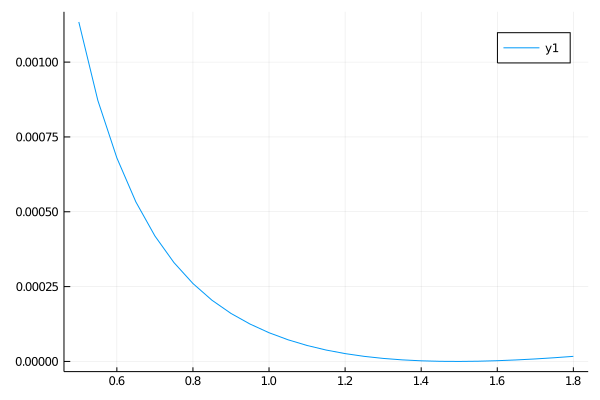

In [14]:
beta_grid = 0.5:0.05:1.8;
obj_grid = zeros(length(beta_grid));
for (i, beta) in enumerate(beta_grid)
    obj_grid[i] = obj_func(
        beta, 
        Pop_array,
        MA_array,
        VA_array,
        num_nomig_array,
        nu,
        N
    );
end
plot(beta_grid, obj_grid)

## Replication of Table 7A

Based on the estimate, I replicate Table 7A which compares the actual consumption and migration with predicted consumption and migration.

In [15]:
N_part_res = zeros(N, 100);
income_weight_res = zeros(N, 100);

if beta_est >= 1.0
    for vil in 1:100
        res = get_income_weight_beta_gt1(
            Pop_array[:, vil],
            MA_array[:, vil],
            VA_array[:, vil],
            beta_est,
            nu
        );
        N_part_res[:, vil] = res[1];
        income_weight_res[:, vil] = res[2];
    end
elseif beta_est < 1.0
    for vil in 1:100
        res = get_income_weight_beta_gt1(
            Pop_array[:, vil],
            MA_array[:, vil],
            VA_array[:, vil],
            beta_est,
            nu
        );
        N_part_res[:, vil] = res[1];
        income_weight_res[:, vil] = res[2];
    end
end


In [16]:
table7a_rep = DataFrame(
    actual_rel_cons = vec(mean(income_weight_array, dims = 2)),
    actual_mig_rate = vec(mean((Pop_array .- num_nomig_array) ./ Pop_array, dims = 2)),
    pred_rel_cons = vec(mean(income_weight_res, dims = 2)),
    pred_mig_rate = vec(mean((Pop_array .- N_part_res) ./ Pop_array, dims = 2))
);
rename!(
    table7a_rep,
    [
        "Rel. Cons. (Actual)",
        "Migration (Actual)",
        "Rel. Cons. (Predicted)",
        "Migration (Predicted)",
    ]);
table7a_rep


,Rel. Cons. (Actual),Migration (Actual),Rel. Cons. (Predicted),Migration (Predicted)
,Float64,Float64,Float64,Float64
1,0.842618,0.0319968,0.815735,5.46224e-6
2,0.854317,0.0340246,0.82554,0.0206282
3,0.870559,0.0504584,0.842215,0.0454476
4,0.886547,0.0462231,0.868263,0.0618535
5,1.0,0.0507197,1.0,0.0854878
